In [5]:
# ----------------------------
# 1. Imports & Data Loading
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import time
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling, RandomSampling
from skactiveml.utils import MISSING_LABEL

# Load dataset
data = pd.read_csv("../../data/simulation_security_labels_n-1.csv")
data["status_binary"] = data["status"].map({"secure": 1, "insecure": 0})

# Drop unused columns
columns_to_drop = [
    "timestamp", "status", "status_binary",
    "max_line_loading_percent_basecase",
    "min_bus_voltage_pu_basecase",
    "max_bus_voltage_pu_basecase",
    "max_line_loading_percent_contingency",
    "min_bus_voltage_pu_contingency",
    "max_bus_voltage_pu_contingency"
]
X = data.drop(columns=columns_to_drop, axis=1, errors="ignore")
y = data["status_binary"]

In [6]:
# ----------------------------
# 2. Split into Pool and Validation Set
# ----------------------------
test_size = 0.1
# X_pool, X_val, y_pool, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

# Manual time split
split_index = int(0.9 * len(X))
X_pool = X.iloc[:split_index]
y_pool = y.iloc[:split_index]
X_val = X.iloc[split_index:]
y_val = y.iloc[split_index:]

In [ ]:
# ----------------------------
# 3. Active Learning Function (skactiveml-based)
# ----------------------------

initial_size = 100
batch_size = 50
iterations = 100
def run_active_learning_skactiveml(X_pool, y_pool, X_val, y_val,
                                   initial_size=initial_size, batch_size=batch_size,
                                   iterations=iterations, strategy_type="uncertainty"):
    # Define base model
    base_model = RandomForestClassifier(n_estimators=100, random_state=42)
    model = SklearnClassifier(estimator=base_model)

    # Initialize strategy
    if strategy_type == "uncertainty":
        strategy = UncertaintySampling()
    elif strategy_type == "random":
        strategy = RandomSampling()
    elif strategy_type == "entropy":
        strategy = UncertaintySampling(method="entropy")
    elif strategy_type == "margin":
        strategy = UncertaintySampling(method="margin_sampling")
    else:
        raise ValueError("Invalid strategy_type")

    # Create initial labeled/unlabeled mask
    y_train = np.full(len(X_pool), MISSING_LABEL)
    initial_idx = np.random.choice(range(len(X_pool)), size=initial_size, replace=False)
    y_train[initial_idx] = y_pool.iloc[initial_idx]

    accuracies = []

    for i in range(iterations):
        model.fit(X_pool, y_train)
        y_pred = model.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        accuracies.append(acc)
        print(f"📈 Iteration {i+1} [{strategy_type}] - Accuracy: {acc:.4f}")

        # Query new samples – conditional logic based on strategy
        # if strategy_type == "uncertainty":
        if strategy_type in ["uncertainty", "entropy", "margin"]:
            query_idx, utilities = strategy.query(
                X_pool, y=y_train, clf=model,
                batch_size=batch_size, return_utilities=True
            )
        else:  # random sampling does NOT take clf
            query_idx = strategy.query(
                X_pool, y=y_train,
                batch_size=batch_size
            )

        # Label newly queried samples
        y_train[query_idx] = y_pool.iloc[query_idx]

    return accuracies

In [8]:
# ----------------------------
# 4. Run Active Learning & Random Sampling
# ----------------------------
start_time = time.time()

acc_active = run_active_learning_skactiveml(X_pool.copy(), y_pool.copy(), X_val, y_val, strategy_type="uncertainty")
acc_random = run_active_learning_skactiveml(X_pool.copy(), y_pool.copy(), X_val, y_val, strategy_type="random")
acc_entropy = run_active_learning_skactiveml(X_pool.copy(), y_pool.copy(), X_val, y_val, strategy_type="entropy")
acc_margin = run_active_learning_skactiveml(X_pool.copy(), y_pool.copy(), X_val, y_val, strategy_type="margin")

end_time = time.time()

📈 Iteration 1 [uncertainty] - Accuracy: 0.8803
📈 Iteration 2 [uncertainty] - Accuracy: 0.8837
📈 Iteration 1 [random] - Accuracy: 0.8586
📈 Iteration 2 [random] - Accuracy: 0.8529
📈 Iteration 1 [entropy] - Accuracy: 0.8951
📈 Iteration 2 [entropy] - Accuracy: 0.8974
📈 Iteration 1 [margin] - Accuracy: 0.8757
📈 Iteration 2 [margin] - Accuracy: 0.8791


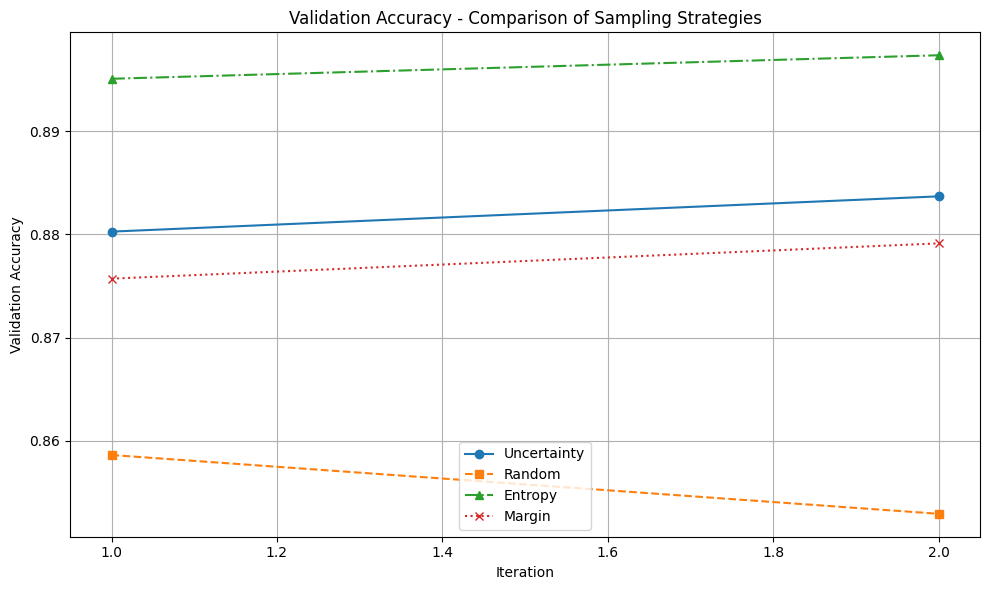

In [9]:
# ----------------------------
# 5. Plot Comparison
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, iterations + 1), acc_active, label="Uncertainty", marker='o')
ax.plot(range(1, iterations + 1), acc_random, label="Random", linestyle='--', marker='s')
ax.plot(range(1, iterations + 1), acc_entropy, label="Entropy", linestyle='-.', marker='^')
ax.plot(range(1, iterations + 1), acc_margin, label="Margin", linestyle=':', marker='x')

ax.set_title("Validation Accuracy - Comparison of Sampling Strategies")
ax.set_xlabel("Iteration")
ax.set_ylabel("Validation Accuracy")
ax.legend()
ax.grid(True)
plt.tight_layout()

In [10]:
# ----------------------------
# 6. Save Comparison Plot & Prepare Metadata Entry & Append Row to CSV Table
# ----------------------------
# Save figure with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_filename = f"../../figures/al_strategy_param_variations/al_manual_temporal_split/active_vs_random_{timestamp}.png"
fig.savefig(plot_filename)
print(f"Plot saved as: {plot_filename}")

total_labeled = initial_size + iterations * batch_size

strategies = {
    "uncertainty": acc_active,
    "random": acc_random,
    "entropy": acc_entropy,
    "margin": acc_margin
}

table_path = "../../tables/active_learning_runs.csv"

fieldnames = [
    "timestamp", "strategy_type", "iterations", "test_size", "initial_size",
    "batch_size", "total_labeled_samples", "accuracy_final",
    "accuracy_mean", "accuracy_std", "duration_sec"
]

file_exists = os.path.isfile(table_path)
with open(table_path, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    if not file_exists:
        writer.writeheader()

    for strategy_name, acc_list in strategies.items():
        run_data = {
            "timestamp": timestamp,
            "strategy_type": strategy_name,
            "iterations": iterations,
            "test_size": test_size,
            "initial_size": initial_size,
            "batch_size": batch_size,
            "total_labeled_samples": total_labeled,
            "accuracy_final": acc_list[-1],
            "accuracy_mean": np.mean(acc_list),
            "accuracy_std": np.std(acc_list),
            "duration_sec": round(end_time - start_time, 2)
        }
        writer.writerow(run_data)

Plot saved as: ../../figures/al_strategy_param_variations/al_manual_temporal_split/active_vs_random_20250514_155812.png
